# 1. Install Dependencies and Setup

In [199]:
!pip install  tensorflow tensorflow-gpu opencv-python  albumentations  
!pip install labelme matplotlib

In [200]:
# !pip uninstall tflite-model-maker
# !conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0
!pip list

Package                       Version
----------------------------- ------------
absl-py                       1.0.0
albumentations                1.1.0
anyio                         3.5.0
apache-beam                   2.39.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
asttokens                     2.0.5
astunparse                    1.6.3
attrs                         21.4.0
audioread                     2.1.9
avro-python3                  1.10.2
Babel                         2.9.1
backcall                      0.2.0
beautifulsoup4                4.11.1
bleach                        4.1.0
brotlipy                      0.7.0
cachetools                    5.2.0
certifi                       2022.5.18.1
cffi                          1.15.0
charset-normalizer            2.0.12
cloudpickle                   2.1.0
colorama                      0.4.4
contextlib2                   21.6.0
crcmod                        1.7
crypto

# 2. Collect Images

In [2]:
import os
import time
import uuid
import cv2

In [17]:
IMAGES_PATH = 'data'
number_images = 23

In [7]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(1)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

# 3. Create Dataset

In [20]:
import tensorflow as tf
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt

In [21]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [31]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg', shuffle=False)

In [32]:
images.as_numpy_iterator().next()

b'data\\images\\15c5ad1f-e74e-11ec-a668-94e23cbfc22c.jpg'

In [22]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [33]:
images = images.map(load_image)

In [34]:
images.as_numpy_iterator().next()


array([[[ 99,  83,  60],
        [ 98,  82,  59],
        [ 97,  81,  58],
        ...,
        [ 41,  65,  69],
        [ 42,  66,  70],
        [ 44,  68,  72]],

       [[ 99,  83,  60],
        [ 98,  82,  59],
        [ 97,  81,  58],
        ...,
        [ 41,  65,  69],
        [ 41,  65,  69],
        [ 43,  67,  71]],

       [[101,  85,  62],
        [100,  84,  61],
        [ 98,  82,  59],
        ...,
        [ 41,  65,  69],
        [ 40,  64,  68],
        [ 41,  65,  69]],

       ...,

       [[208, 166,  90],
        [206, 164,  88],
        [206, 164,  90],
        ...,
        [ 32,  38,  34],
        [ 27,  33,  29],
        [ 25,  31,  27]],

       [[215, 173,  97],
        [212, 170,  94],
        [207, 165,  91],
        ...,
        [ 30,  36,  34],
        [ 25,  34,  31],
        [ 24,  33,  30]],

       [[214, 172,  96],
        [214, 172,  96],
        [210, 168,  94],
        ...,
        [ 28,  34,  32],
        [ 26,  35,  34],
        [ 29,  38,  37]]

In [35]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

# 4. Move Matching Labels AFTER Annotation with Labelme

In [67]:
#for folder in ['train','test','val']:
for file in os.listdir(os.path.join('data', 'images')):

    filename = file.split('.')[0]+'.json'
    existing_filepath = os.path.join('data','labels', filename)
    if os.path.exists(existing_filepath): 
        new_filepath = os.path.join('data','labels',filename)
        os.replace(existing_filepath, new_filepath)  

# 5. Image Augmentation

In [28]:
import albumentations as alb
import random

In [197]:
random.seed(7)
augmentor = alb.Compose([
                    # alb.RandomCrop(width=450, height=450), 
                        # A.RandomSizedCrop(min_max_height=(256, 1025), height=512, width=512, p=0.5),
                    alb.ShiftScaleRotate (shift_limit=[-0.1,0.1], scale_limit=[-0.2, 0.05], rotate_limit=45, interpolation=1, border_mode=4, p=0.9),
                    alb.HueSaturationValue(p=0.5), 
                    alb.RandomBrightnessContrast(p=0.5),
                    alb.RandomGamma(p=0.5), 
                    alb.RGBShift(p=0.5), ],
                    keypoint_params=alb.KeypointParams(format='xy', label_fields=['class_labels'], remove_invisible=False, angle_in_degrees=True)
                    )

In [190]:
KEYPOINT_COLOR = (0, 255, 0) # Green

def vis_keypoints(image, keypoints, classes, color=KEYPOINT_COLOR, diameter=5):
    #image = image.copy()
    
    for i in range(6):
        cv2.circle(image, (int(keypoints[i][0]), int(keypoints[i][1])), diameter, KEYPOINT_COLOR, -1)
        cv2.putText(img=image, text=classes[i], org=(int(keypoints[i][0]), int(keypoints[i][1])), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=KEYPOINT_COLOR,thickness=1)
        
    #for i in range(0,12,2):
    #    cv2.circle(image, (int(keypoints[i]), int(keypoints[i+1])), diameter, color, -1)
        
        
        print(i)
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(image)

In [191]:
def read_keypoints(label_path):    # JSON of labels for an image in labelme default keypoint format, array to hold keypoint coordinates
    with open(label_path, 'r') as f:
        labeljson = json.load(f)
    kypts = [(0,0),(0,0),(0,0),(0,0),(0,0),(0,0)]        
    w = labeljson['imageWidth']
    h = labeljson['imageHeight']
    # iterate over labels. Add (x, y) for each point
    for i in labeljson['shapes']:                    # shapes is an array of labelled shapes. For this app, each shape contains an array named 'points' with 1 keypoint
        if i['label']=='tl': 
            # classes[0] = 1
            # points is an array len()=1 of points, each of which is a len() 2 array of type float coordinates 
            kypts[0] = (np.squeeze(i['points'])[0],  np.squeeze(i['points'])[1])
            #kypts[0] = np.squeeze(i['points'])[0]
            #kypts[1] = np.squeeze(i['points'])[1]
        if i['label']=='tr':
            # classes[1] = 1
            kypts[1] = (np.squeeze(i['points'])[0],  np.squeeze(i['points'])[1])
            # kypts[2] = np.squeeze(i['points'])[0]
            # kypts[3] = np.squeeze(i['points'])[1]
        if i['label']=='bl':
            # classes[2] = 1
            kypts[2] = (np.squeeze(i['points'])[0],  np.squeeze(i['points'])[1])
            # kypts[4] = np.squeeze(i['points'])[0]
            #kypts[5] = np.squeeze(i['points'])[1]
        if i['label']=='br':
            # classes[3] = 1
            kypts[3] = (np.squeeze(i['points'])[0],  np.squeeze(i['points'])[1])
            # kypts[6] = np.squeeze(i['points'])[0]
            # kypts[7] = np.squeeze(i['points'])[1]
        if i['label']=='ll':
            # classes[4] = 1
            kypts[4] = (np.squeeze(i['points'])[0],  np.squeeze(i['points'])[1])
            # kypts[8] = np.squeeze(i['points'])[0]
            # kypts[9] = np.squeeze(i['points'])[1]
        if i['label']=='lr':
            # classes[5] = 1
            kypts[5] = (np.squeeze(i['points'])[0],  np.squeeze(i['points'])[1])
            # kypts[10] = np.squeeze(i['points'])[0]
            # kypts[11] = np.squeeze(i['points'])[1]

    
    
    # np.divide(coords, [w,h,w,h,w,h,w,h,w,h,w,h])
    return kypts, w, h

0
1
2
3
4
5


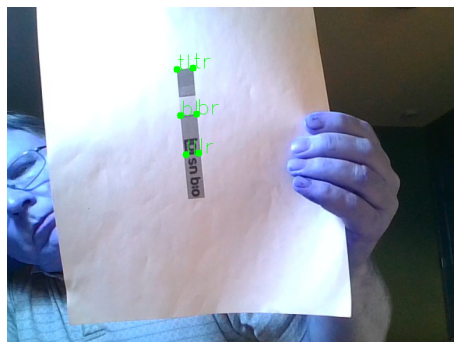

In [192]:
kpt, w, h = read_keypoints('data/labels/15c5ad1f-e74e-11ec-a668-94e23cbfc22c.json')
#print(kpt)
im = cv2.imread('data/images/15c5ad1f-e74e-11ec-a668-94e23cbfc22c.jpg')
vis_keypoints(im, kpt, class_labels)


In [ ]:
#for partition in ['train', 'test', 'val']: 
partition = 'train'
# doing augmentation on whole image set. Will partition later
# expecting images in 'data/images' and labelme keypoint labels in 'data/labels'

class_labels = ['tl','tr','bl','br','ll','lr']

for imagename in os.listdir(os.path.join('data', 'images')):                # partition,   # image filename
    img = cv2.imread(os.path.join('data',  'images', imagename))             #partition,
    #coords = [0,0,0,0,0,0,0,0,0,0,0,0]
    # classes = [1,1,1,1,1,1]
        # grab filename for each image and check for corresponding json
    label_path = os.path.join('data', 'labels', f'{imagename.split(".")[0]}.json')       # partition,   

    if os.path.exists(label_path):    # there may be images with no keypoints, so no label file
       # coords = read_keypoints(label_path, coords)
        keypoints, w, h  = read_keypoints(label_path)
        #print(transformed['class_labels'])

        try: 
            for x in range(150):
                
                  # [(coords[:2]), (coords[2:])]
                transformed = augmentor(image=img, keypoints=keypoints, class_labels=class_labels)
                #print(transformed['keypoints'])
                newimgname = f'{imagename.split(".")[0]}.{x}.jpg'
                #print(newimgname, x)
                cv2.imwrite(os.path.join('augdata', partition, 'images', f'{imagename.split(".")[0]}.{x}.jpg'), transformed['image'])

                annotation = {}
                annotation['image'] = newimgname
                annotation['class'] = [0,0,0,0,0,0]
                annotation['class_labels'] = transformed['class_labels']
                annotation['keypoints'] = [0,0,0,0,0,0,0,0,0,0,0,0]

                if os.path.exists(label_path):
                    if len(transformed['keypoints']) > 0: 
                        for idx, cl in enumerate(transformed['class_labels']):
                            if cl == 'tl': 
                                annotation['class'][0] = 1 
                                annotation['keypoints'][0] = transformed['keypoints'][idx][0]
                                annotation['keypoints'][1] = transformed['keypoints'][idx][1]
                            if cl == 'tr': 
                                annotation['class'][1] = 1 
                                annotation['keypoints'][2] = transformed['keypoints'][idx][0]
                                annotation['keypoints'][3] = transformed['keypoints'][idx][1]
                            if cl == 'bl': 
                                annotation['class'][2] = 1 
                                annotation['keypoints'][4] = transformed['keypoints'][idx][0]
                                annotation['keypoints'][5] = transformed['keypoints'][idx][1]
                            if cl == 'br': 
                                annotation['class'][3] = 1 
                                annotation['keypoints'][6] = transformed['keypoints'][idx][0]
                                annotation['keypoints'][7] = transformed['keypoints'][idx][1]
                            if cl == 'll': 
                                annotation['class'][4] = 1 
                                annotation['keypoints'][8] = transformed['keypoints'][idx][0]
                                annotation['keypoints'][9] = transformed['keypoints'][idx][1]
                            if cl == 'lr': 
                                annotation['class'][5] = 1 
                                annotation['keypoints'][10] = transformed['keypoints'][idx][0]
                                annotation['keypoints'][11] = transformed['keypoints'][idx][1]
                                
                     
                annotation['image_width'] = w
                annotation['image_height'] = h
                #print(annotation.keys())
                #print("Annotation image: ", annotation['image'])
                auglabelpath = os.path.join('augdata', partition, 'labels', f'{imagename.split(".")[0]}.{x}.json')
                print(auglabelpath)
                with open(auglabelpath, 'w') as f:
                    json.dump(annotation, f)
                # annotation['keypoints'] = list(np.divide(annotation['keypoints'], [450,450,450,450]))
                
             
        except Exception as e:
            print("exception ", e, ", ", imagename)
            print(e)


dict_keys(['image', 'class', 'class_labels', 'keypoints', 'image_width', 'image_height'])
Annotation image:  15c5ad1f-e74e-11ec-a668-94e23cbfc22c.0.jpg
augdata\train\labels\15c5ad1f-e74e-11ec-a668-94e23cbfc22c.0.json
dict_keys(['image', 'class', 'class_labels', 'keypoints', 'image_width', 'image_height'])
Annotation image:  15c5ad1f-e74e-11ec-a668-94e23cbfc22c.1.jpg
augdata\train\labels\15c5ad1f-e74e-11ec-a668-94e23cbfc22c.1.json
dict_keys(['image', 'class', 'class_labels', 'keypoints', 'image_width', 'image_height'])
Annotation image:  15c5ad1f-e74e-11ec-a668-94e23cbfc22c.2.jpg
augdata\train\labels\15c5ad1f-e74e-11ec-a668-94e23cbfc22c.2.json
dict_keys(['image', 'class', 'class_labels', 'keypoints', 'image_width', 'image_height'])
Annotation image:  15c5ad1f-e74e-11ec-a668-94e23cbfc22c.3.jpg
augdata\train\labels\15c5ad1f-e74e-11ec-a668-94e23cbfc22c.3.json
dict_keys(['image', 'class', 'class_labels', 'keypoints', 'image_width', 'image_height'])
Annotation image:  15c5ad1f-e74e-11ec-a668

In [180]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
    return [label['keypoints']]

In [ ]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))